# LGBM Model
* RNN was far too slow and hence infeasible given the time limit I am constrained within
* So going to use an LGBM
* Just comment out the plots when running if not needing to regenerate them

# Misc / setting up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import datetime
from IPython.display import display
from pprint import pprint
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
import time
from sklearn import preprocessing
import seaborn as sns
import gc

In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf

In [2]:
import random
SEED = 1337
random.seed(SEED)

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# loading the data

In [4]:
df_train = pd.read_pickle("../Data/Prepared_Data/supervised/consumption_all.pkl")
display(df_train)
df_preds = pd.read_pickle("../Data/Prepared_Data/supervised/consumption_all_preds.pkl")
display(df_preds)

,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,1,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.5170
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,2.9330
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.0850
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.2370
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,4.4710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640294,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,18.7585
640295,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,21.0110
640296,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,19.2040
640297,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,17.3970


,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,NaN
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,NaN
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,NaN
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,NaN
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,NaN
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,NaN
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,NaN
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,NaN


# formatting the df's

In [5]:
#replacing nans with 0 so we can aggregate up the OOF predictions
df_preds["meter_reading"] = df_preds["meter_reading"].fillna(0) 
#dropping the "energy n-k" columns as they are needed for 3D RNN input not 2D LGBM input
# df_preds = df_preds.drop(["energy n-7","energy n-6","energy n-5","energy n-4","energy n-3","energy n-2","energy n-1"], axis=1)
# df_train = df_train.drop(["energy n-7","energy n-6","energy n-5","energy n-4","energy n-3","energy n-2","energy n-1"], axis=1)

display(df_train)
display(df_preds)

,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,1,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.5170
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,2.9330
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.0850
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.2370
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,4.4710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640294,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,18.7585
640295,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,21.0110
640296,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,19.2040
640297,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,1.0,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,17.3970


,meter_id,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,meter_id_8,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,0,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,0,1,1,0,0,1,0,1,1,...,0.841254,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,0


# Ordinally encoding the ID's
* One hot / binary encoding can actually worsen performance of DT based algorithms
* and LGBM supports categorical values; so no need to use the binary encoded meter_id which we planned for the RNN
* Hence I will also now encode the ID ordinally and experiment with both to see which gives the best performing results

In [6]:
#ordinally encoding id's
le = preprocessing.LabelEncoder()
le.fit(df_preds["meter_id"])

#ordinally encoding with same encoder so will encode the same
df_train.insert(1, "meter_id_ord", le.transform(df_train["meter_id"]))
df_preds.insert(1, "meter_id_ord", le.transform(df_preds["meter_id"]))

display(df_train)
display(df_preds)

,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,1.0,1,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.5170
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,2.9330
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.0850
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,3.2370
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,1.0,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,4.4710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640294,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,18.7585
640295,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,21.0110
640296,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1.0,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,19.2040
640297,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1.0,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,17.3970


,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,month_cos,is_weekend,energy_cluster,num_bedrooms,dwelling_type,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0.841254,0,0,2.0,terraced_house,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,0,2,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0.841254,1,2,3.0,detached_house,1.0,0.0,0.0,0.0,0


# Ordinally encoding the dwelling_type
* same reasons for replacing the binary encoded meter_id with ordinal encoding; going to replace one hot encodede dwelling type with ordinal encoding

In [7]:
#ordinally encoding dwelling_type
le = preprocessing.LabelEncoder()
le.fit(df_preds["dwelling_type"])

#ordinally encoding with same encoder so will encode the same
df_train.insert(27, "dwelling_type_ord", le.transform(df_train["dwelling_type"]))
df_preds.insert(27, "dwelling_type_ord", le.transform(df_preds["dwelling_type"]))

display(df_train)
display(df_preds)

,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,is_weekend,energy_cluster,num_bedrooms,dwelling_type,dwelling_type_ord,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,1,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,3.5170
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,2.9330
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,3.0850
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,3.2370
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,4.4710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640294,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,18.7585
640295,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,21.0110
640296,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,19.2040
640297,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,17.3970


,meter_id,meter_id_ord,meter_id_0,meter_id_1,meter_id_2,meter_id_3,meter_id_4,meter_id_5,meter_id_6,meter_id_7,...,is_weekend,energy_cluster,num_bedrooms,dwelling_type,dwelling_type_ord,detached,flat,semi_detached,terraced,meter_reading
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
1,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
2,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
3,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
4,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,2073,0,0,0,0,0,0,0,0,...,0,0,2.0,terraced_house,4,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185515,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185516,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,0,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185517,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,0
1185518,0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd,2605,0,1,1,0,0,1,0,1,...,1,2,3.0,detached_house,1,1.0,0.0,0.0,0.0,0


# SKF-CV for training the LGBM
* Using skf on df_train by meter_id with 3 folds
    * Meaning for each iteration we use 2/3 of each meters data for training and 1/3 of each meters data for validating
* using out of fold predictions, making predictions on each fold and aggregating them together for the final prediction

* evaluates the model via OOF predictions made on the held out set on each fold
* this score is returned and along with the 3 models
* firefly algorithm hyper parameter tuning will then be used to find the LGBM hyper param config with the best val score and this will then be used to make predictions using the model which has the best validation score

In [8]:
# REFERENCE the lgbm used inside this function has taken inspiration from the proposed model in the work of Wenlong Wu's : "Solution to the IEEE-CIS Second Technical Challenge with Machine Learning Modeling"

import warnings
warnings.filterwarnings("ignore")

#function for running the cross fold
    #args:
        #disp_fold_info = True if we want to print info for each fold
        #disp_end_info = True if we want to display evaluation info at the end
        #SEED = random seed used for fair repeatability
        #num_folds = number of folds in skf (pretty certain going to keep this at 3 )
        #df_train = training dataframe
        #y_col = the name of the label we want to predict (meter_reading)
        #X_cols = the name of the feature columns we are using
        #X_cat = the name of these features which are categorical
        #params = hyper params for the LGBM model
    #returns:
        #time_of_execution = how long it took to train the model on all folds; will be used as a point of comparison
        #valid_score = MAE calculated using the Out-of-Fold Predictions on the df_train, used for hyper-param tuning
        #lgbm_models = array of the different lgbm_models
        
def run_lgbm_skf_cv(disp_fold_info, disp_end_info, SEED, num_folds, df_train, y_col, X_cols, X_cat, params):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = SEED) # defining the SKF algorithm

    lgbm_models = []
    start_time = time.time()
    fold_iter=1
    #running the startified kfold, splitting df_train by meter_id, so we use 2/3 of each meters reading for training
    for train_index, valid_index in skf.split(df_train, df_train["meter_id"]):

        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Fold {fold_iter}{color.END}")
        
        #splitting into the features and labels for the train and valid folds
        X_train, X_valid = df_train.loc[train_index, X_cols], df_train.loc[valid_index, X_cols]
        y_train, y_valid = df_train.loc[train_index, y_col], df_train.loc[valid_index, y_col]
        
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}X_train{color.END}")
            display(X_train.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}y_train{color.END}")
            display(y_train.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}X_valid{color.END}")
            display(X_valid.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}y_valid{color.END}")
            display(y_valid.head(5))
            
        print(f"{color.CYAN}{color.UNDERLINE}Training the LGBM{color.END}")
        #instantiating a lgbm regressor with our params
        lgbm_model = lgbm.LGBMRegressor(**params)
        #fitting the lgbm model on the 2/3 train and evaluating on the 1/3 valid
        #printing details every 1000 iters + stopping if no improvement made in 250 iters
        lgbm_model.fit(X_train, y_train,
                       eval_set=[(X_valid, y_valid)],
                       categorical_feature=X_cat,
                       verbose=3333,
                       early_stopping_rounds=250)
        
        #saving the OOF prediction for the held out rows (valid rows from df_train) from the lgbm model with the best performing intrinisic parmams 
        oof_valid = lgbm_model.predict(X_valid, num_iteration=lgbm_model.best_iteration_) # making prediction on the held out rows, X_valid
        df_train.loc[valid_index, "oof"] = oof_valid #storing the oof rows 
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}df_train OOF predictions{color.END}")
            display(df_train.loc[valid_index, ["meter_id","oof"]].head(5))
               
        #appending this lgbm
        lgbm_models.append(lgbm_model)
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}lgbm_models size{color.END}: {len(lgbm_models)}")
            
        fold_iter+=1
        
    
    #calculating execution time and the MAE on the training set
    time_of_execution = time.time() - start_time
    valid_score=mean_absolute_error(df_train[y_col], df_train["oof"]) 
    
    if(disp_end_info):
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}training set OOF preds vs true{color.END}")
        display(df_train[["meter_id","date","meter_reading","oof"]])
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:  {color.END}{str(datetime.timedelta(seconds=round(time_of_execution)))}\n")
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {valid_score}\n")
    
    
    
    return (time_of_execution, valid_score, lgbm_models)


# Running FA hyper param optim on the LGBM skf-cv function


In [9]:
y_col = "meter_reading" #we want to predict the meter_reading (this will always be the same)

## Setting the column types and grouping ones together that should be grouped

In [10]:
#dictionary to hold all groups of columns which could be chosen
#done as if we just pick columns completely random we may get just "meter_id_3" from the binary encoded meter_id's
#wouldn't make any sense without the other respective binary encoded meter_id columns

possible_columns = {}
possible_columns["meter_id_ord"] = ["meter_id_ord"]
possible_columns["meter_id_binary"] = ['meter_id_0', 'meter_id_1', 'meter_id_2',
       'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
       'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12']
possible_columns["day_of_year_cyclic"] = ["day_of_year_sin","day_of_year_cos"]
possible_columns["day_of_week"] = ["day_of_week"]
possible_columns["day_of_month"] = ["day_of_month"]
possible_columns["month_ord"] = ["month_ord"]
possible_columns["month_cyclic"] = ["month_sin","month_cos"]
possible_columns["is_weekend"] = ["is_weekend"]
possible_columns["energy_cluster"] = ["energy_cluster"]
possible_columns["num_bedrooms"] = ["num_bedrooms"]
possible_columns["dwelling_type_ord"] = ["dwelling_type_ord"]
possible_columns["dwelling_type_onehot"] = ['detached', 'flat', 'semi_detached', 'terraced']
pprint(possible_columns)

{'day_of_month': ['day_of_month'],
 'day_of_week': ['day_of_week'],
 'day_of_year_cyclic': ['day_of_year_sin', 'day_of_year_cos'],
 'dwelling_type_onehot': ['detached', 'flat', 'semi_detached', 'terraced'],
 'dwelling_type_ord': ['dwelling_type_ord'],
 'energy_cluster': ['energy_cluster'],
 'is_weekend': ['is_weekend'],
 'meter_id_binary': ['meter_id_0',
                     'meter_id_1',
                     'meter_id_2',
                     'meter_id_3',
                     'meter_id_4',
                     'meter_id_5',
                     'meter_id_6',
                     'meter_id_7',
                     'meter_id_8',
                     'meter_id_9',
                     'meter_id_10',
                     'meter_id_11',
                     'meter_id_12'],
 'meter_id_ord': ['meter_id_ord'],
 'month_cyclic': ['month_sin', 'month_cos'],
 'month_ord': ['month_ord'],
 'num_bedrooms': ['num_bedrooms']}


In [11]:
# setting categorical columns

all_cat = ["meter_id_ord", 'meter_id_0', 'meter_id_1', 'meter_id_2',
           'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
           'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12',
           "day_of_week", "day_of_month", "month_ord", "is_weekend", "energy_cluster",
           "dwelling_type_ord", "detached", "flat", "semi_detached", "terraced"] #all categorical values

# setting categorical columns in the dataframe to be categorical
#X_cat[0] holds all columns (besides clusters but we aren't using that) 
for i in all_cat:
    df_train[i] = df_train[i].astype('category')
    df_preds[i] = df_preds[i].astype('category')

### Defining the model parameters for FA
* sensible different combinations of params for the model

* default values which make sense and the others have place holders as they will be found in FA

In [12]:
#default params (including ones we will override and those we won't)
params = {
    ### won't be tuned ###
    'boosting_type': 'gbdt', #gbdt/rf/dart/goss
    'metric': 'mae', 
    'num_threads': -1, # number of threads to run on for speed (auto)
    'num_iterations': 10000, #defining the models runs
    'seed': SEED, # all runs with same seed for better comparison between different hyper params
    
    ### will be tuned (replace these with the best performing) ###
    'learning_rate': 0.99999,
    'num_leaves': 99999, # limit max numer of leaves in a tree
    "max_depth":99999, # limit max depth of the tree to prevent overfitting
    # fraction to be bagged/sampled every k iterations
    'bagging_fraction': 0.99999,
    'bagging_freq' : 99999,
    'feature_fraction': 0.99999, # fraction of features to use at each tree node
    #l1 & l2 regularization to prevent overfitting
    "lambda_l1": 99999,
    "lambda_l2": 99999
}

pprint(params)

{'bagging_fraction': 0.99999,
 'bagging_freq': 99999,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.99999,
 'lambda_l1': 99999,
 'lambda_l2': 99999,
 'learning_rate': 0.99999,
 'max_depth': 99999,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 99999,
 'num_threads': -1,
 'seed': 1337}


In [13]:
#array of names of keys for the params we tune in the dic ; will be used in mutation of FA
tuned_hyper_names = ["learning_rate","num_leaves","max_depth","bagging_fraction","bagging_freq","feature_fraction","lambda_l1","lambda_l2"]
whole_number_hyper_names = ["num_leaves","max_depth","bagging_freq","lambda_l1","lambda_l2"]
fractional_hyper_names = ["bagging_fraction","feature_fraction"]

## Running the Firefly Hyper Param Optimization
### creating the initial population

In [14]:
population_size = 16

In [15]:
population = []
# loading the description of the best model from RS and the RS main effects to be used as 2 of the original population
# rs_best_model = pd.read_pickle("../Results/Unclustered Random Search/64_best_model_desc.pkl")
# rs_best_model_features = rs_best_model["features"]
# rs_best_model_col_groups = []
# for key in possible_columns.keys():
#     if(possible_columns[key][0] in rs_best_model_features):
#         rs_best_model_col_groups+=[key]
# population.append((rs_best_model_features,rs_best_model["params"], rs_best_model_col_groups))

# rs_main_effects_model = pd.read_pickle("../Results/Unclustered Random Search/64_main_effects_desc.pkl")
# rs_main_effects_features = rs_main_effects_model["features"]
# rs_main_effects_col_groups = []
# for key in possible_columns.keys():
#     if(possible_columns[key][0] in rs_main_effects_features):
#         rs_main_effects_col_groups+=[key]
# population.append((rs_main_effects_features,rs_best_model["params"], rs_main_effects_col_groups))

#filling the rest of the population with random models
while (len(population)<population_size):
    #firstly randomly picking the features we will use
    X_cols = []#this will store the X_cols we use
    X_col_groups = []
    #generating probability of accepting each column
    prob_to_beat = random.randrange(30,100)/100 #between 0.3 and 1
    #iterating through each column and randomly decide whether or not to pick it
    for key in possible_columns.keys():
        #randomly generate a decimal for this column group
        this_prob = random.randrange(0,100)/100 #between 0 and 1
        #if this is less than the probability to beat then accept it
        if(this_prob<=prob_to_beat):
            X_col_groups+=[key]
            X_cols+=possible_columns[key]
    if(len(X_col_groups)<=0):
        new_key=random.choice(list(possible_columns.keys()))
        X_col_groups=[new_key]
        X_cols+=possible_columns[new_key]
        print(f"No columns clipping length to 1 so randomly choosing to use {new_key}")

    #then get LGBM hyper parameters
    this_params = params.copy()
    this_params["learning_rate"] = random.randrange(10,100)/1000 #between 0.01 and 0.1
    this_params["max_depth"] = random.randrange(6,12)
    this_params["num_leaves"] = random.randrange(np.round(2**(this_params["max_depth"])*0.5), np.round(2**(this_params["max_depth"])*1)) #picking a random max leaves less than 2^(max_depth) to prevent over fitting (between 50 and 100%)
    this_params["bagging_fraction"] = random.randrange(50,100)/100 #between 0.5 and 1
    this_params["bagging_freq"] = random.randrange(5,25)
    this_params["feature_fraction"] = random.randrange(50,100)/100 #between 0.5 and 1
    this_params["lambda_l1"] = random.randrange(4,20)
    this_params["lambda_l2"] = random.randrange(4,20)
    
    #adding this random model to the initial population
    population.append((X_cols,this_params,X_col_groups))
    
#viewing the initial population
print(f"{color.BOLD}The initial population is{color.END}\n")
for i in range(len(population)):
    print(f"{color.BOLD}{color.RED}{color.UNDERLINE}population member {i}{color.END}")
    print(f"{color.BOLD}features{color.END}\n",population[i][0])
    print(f"{color.BOLD}feature groups{color.END}\n",population[i][2])
    print(f"{color.BOLD}labels{color.END}")
    pprint(population[i][1])
    print()

The initial population is

population member 0
features
 ['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'day_of_month', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'detached', 'flat', 'semi_detached', 'terraced']
feature groups
 ['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'day_of_month', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'dwelling_type_onehot']
labels
{'bagging_fraction': 0.98,
 'bagging_freq': 16,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.56,
 'lambda_l1': 17,
 'lambda_l2': 16,
 'learning_rate': 0.06,
 'max_depth': 11,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 1443,
 'num_threads': -1,
 'seed': 1337}

population member 1
features
 ['num_bedroom

### Running the firefly algorithm

* 12 fireflies * 20 iterations = 240 models

<b> this one doesn't store the lgbm model as my machine was running out of memory due to the FA being more complicated. Instead will just save the description and will have to retrain the best one with that description at the end of the algorithm </b>

Firefly Algorithm hyper parameter optimization



  0%|          | 0/8 [00:00<?, ?it/s]

Training the fireflies


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 0, Firefly 0
Feature groups
['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'day_of_month', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.06, 'num_leaves': 1443, 'max_depth': 11, 'bagging_fraction': 0.98, 'bagging_freq': 16, 'feature_fraction': 0.56, 'lambda_l1': 17, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.98, subsample=1.0 will be ignored. Current value: bagging_fraction=0.98
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] 

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.78424
[6666]	valid_0's l1: 2.7419
[9999]	valid_0's l1: 2.71922
Did not meet early stopping. Best iteration is:
[9999]	valid_0's l1: 2.71922
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.62, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.62
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.80669
[666

[LightGBM] [Warning] feature_fraction is set=0.53, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.53
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_fraction is set=0.97, subsample=1.0 will be ignored. Current value: bagging_fraction=0.97
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.95829
[6666]	valid_0's l1: 1.90724
[9999]	valid_0's l1: 1.88189
Did not meet early stopping. Best iteration is:
[9998]	valid_0's l1: 1.88189
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.53, colsample_bytree=1.0 will be ignored. Cur

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.0522
[6666]	valid_0's l1: 2.01955
[9999]	valid_0's l1: 2.00638
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 2.00638
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.69, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.69
[LightGBM] [Warning] lambda_l1 is set=14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.05522

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.68, subsample=1.0 will be ignored. Current value: bagging_fraction=0.68
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.96552
[6666]	valid_0's l1: 1.93825
[9999]	valid_0's l1: 1.92436
Did not meet early stopping. Best iteration is:
[9996]	valid_0's l1: 1.92436
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1

[9999]	valid_0's l1: 1.83643
Did not meet early stopping. Best iteration is:
[9966]	valid_0's l1: 1.83638
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.93997
[6666]	valid_0's l1: 1.87791
[9999]	valid_0's l1: 1.84462
Did not meet early stopping. Best iteration is:
[9998]	valid_0's 

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[1061]	valid_0's l1: 2.00988
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93
[LightGBM] [Warning] lambda_l1 is set=9, re

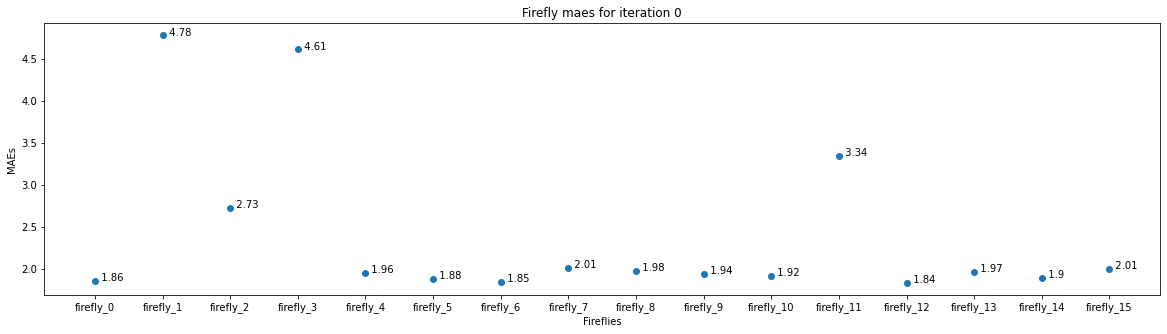


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.2888, 0.0438, 0.1346, 0.047, 0.2615, 0.2826, 0.2914, 0.2473, 0.2561, 0.2646, 0.2704, 0.0896, 0.2951, 0.2579, 0.2772, 0.2483]

firefly_ranked_indexes
[12, 6, 0, 5, 14, 10, 9, 4, 13, 8, 15, 7, 2, 11, 3, 1]

firefly ranked intensities
[0.295, 0.291, 0.289, 0.283, 0.277, 0.27, 0.265, 0.261, 0.258, 0.256, 0.248, 0.247, 0.135, 0.09, 0.047, 0.044]

Moving the fireflies
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 6 MAE = 1.8523493855127717 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 0 MAE = 1.860704092174566 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 5 MAE = 1.8810887902009288 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 14 MAE = 1.8994828987927745 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 10 MAE = 1.92317259033372 | B is better than A? False
Firefly_

lambda_l1 has changed from 9 to 9.00007152411114 taking a step of size 0.015625
lambda_l2 has changed from 10 to 10.000357620555702 taking a step of size 0.015625
Decided to keep using meter_id_ord as firefly 15 already uses it
Decided to stop using meter_id_binary as firefly 15 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 15 doesn't already use it
Decided to keep using day_of_week as firefly 15 already uses it
Decided to stop using day_of_month as firefly 15 doesn't already use it
Decided to keep using month_ord as firefly 15 already uses it
Decided to stop using month_cyclic as firefly 15 doesn't already use it
Decided to stop using is_weekend as firefly 15 doesn't already use it
Decided to stop using energy_cluster as firefly 15 doesn't already use it
Decided to stop using num_bedrooms as firefly 15 doesn't already use it
Decided to keep using dwelling_type_ord as firefly 15 already uses it
Decided to stop using dwelling_type_onehot as firefly 15 doesn'

Decided to stop using dwelling_type_onehot as firefly 2 doesn't already use it
Firefly_A = 2 MAE = 2.7260851289410333 | Firefly_B = 7 MAE = 2.0109767224469666 | B is better than A? True
Intensity difference between 2 and 7 is 0.031697387421177836
learning_rate has changed from 0.021170654397775275 to 0.0211705588930765 taking a step of size 0.00048828125
num_leaves has changed from 1003 to 1002.9851573268862 taking a step of size 0.00048828125
max_depth has changed from 11 to 10.99992261380024 taking a step of size 0.00048828125
bagging_fraction has changed from 0.9004795638532521 to 0.9004797112033268 taking a step of size 0.00048828125
bagging_freq has changed from 11 to 11.000108340679661 taking a step of size 0.00048828125
feature_fraction has changed from 0.6166134286995837 to 0.6166145645211569 taking a step of size 0.00048828125
lambda_l1 has changed from 7 to 7.000108340679662 taking a step of size 0.00048828125
lambda_l2 has changed from 13 to 13.000046431719856 taking a step 

  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 1, Firefly 0
Feature groups
['meter_id_ord', 'month_ord', 'is_weekend', 'num_bedrooms', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.06006412041762353, 'num_leaves': 1441, 'max_depth': 11, 'bagging_fraction': 0.9798639126605562, 'bagging_freq': 16, 'feature_fraction': 0.5600146868078545, 'lambda_l1': 17, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5600146868078545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5600146868078545
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9798639126605562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9798639126605562
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambd

[9999]	valid_0's l1: 1.97436
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.97434
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6166145645211569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6166145645211569
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.9004797112033268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9004797112033268
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.98326
[6666]	valid_0's l1: 1.97017
[9999]	valid_0's l1: 1.9633
Did not

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99415
Early stopping, best iteration is:
[6311]	valid_0's l1: 1.98184
MAE = 1.9787538081869889, TOE = 0:24:05, Intensity = 0.25539740052080145

Iteration 1, Firefly 5
Feature groups
['meter_id_ord', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.015366753399420957, 'num_leaves': 402, 'max_depth': 9, 'bagging_fraction': 0.9697148243057885, 'bagging_freq': 9, 'feature_fraction': 0.5302054549701243, 'lambda_l1': 18, 'lambda_l2': 15}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5302054549701243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5302054549701243
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.66211
Early stopping, best iteration is:
[3474]	valid_0's l1: 2.66138
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6872082276900213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6872082276900213
[LightGBM] [Warning] lambda_l1 is set=14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14
[LightGBM] [Warning] bagging_fraction is set=0.910006744058865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.910006744058865
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.65164
Early stopping, 

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[555]	valid_0's l1: 2.6108
MAE = 2.6125065508765157, TOE = 0:05:20, Intensity = 0.14651605741535645

Iteration 1, Firefly 10
Feature groups
['meter_id_ord', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.01577475593383858, 'num_leaves': 2019, 'max_depth': 11, 'bagging_fraction': 0.6827573535515451, 'bagging_freq': 5, 'feature_fraction': 0.5897833465577077, 'lambda_l1': 8, 'lambda_l2': 18}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5897833465577077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897833465577077
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.68275735355154

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.93685
[6666]	valid_0's l1: 1.87481
[9999]	valid_0's l1: 1.84136
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.84135
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.93325
[6

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.10187
[6666]	valid_0's l1: 2.07005
[9999]	valid_0's l1: 2.05451
Did not meet early stopping. Best iteration is:
[9981]	valid_0's l1: 2.05437
MAE = 2.0483397086799857, TOE = 0:31:16, Intensity = 0.23833950418612562

Iteration 1, Firefly 15
Feature groups
['meter_id_ord', 'day_of_week', 'month_ord', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.060442035782627884, 'num_leaves': 345, 'max_depth': 9, 'bagging_fraction': 0.5098234041398614, 'bagging_freq': 20, 'feature_fraction': 0.9215237815238836, 'lambda_l1': 9, 'lambda_l2': 10}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.9215237815238836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9215237815238836
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lamb

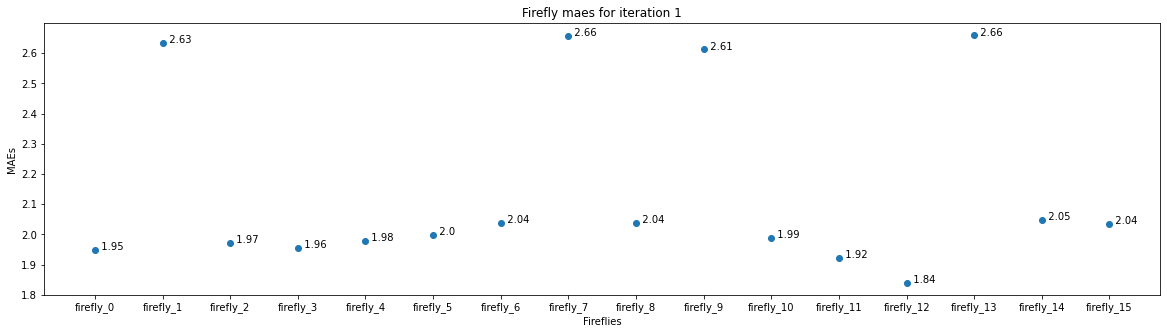


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.2635, 0.1441, 0.2576, 0.2616, 0.2554, 0.2501, 0.241, 0.1415, 0.2411, 0.1465, 0.2527, 0.2705, 0.2951, 0.1415, 0.2383, 0.2414]

firefly_ranked_indexes
[12, 11, 0, 3, 2, 4, 10, 5, 15, 8, 6, 14, 9, 1, 7, 13]

firefly ranked intensities
[0.295, 0.271, 0.264, 0.262, 0.258, 0.255, 0.253, 0.25, 0.241, 0.241, 0.241, 0.238, 0.147, 0.144, 0.142, 0.141]

Moving the fireflies
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 11 MAE = 1.9225556836035689 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 0 MAE = 1.9479970973460554 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 3 MAE = 1.955115483932803 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 2 MAE = 1.9704512943881238 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 4 MAE = 1.9787538081869889 | B is better than A? False
Firefl

learning_rate has changed from 0.07136535973044542 to 0.071246825771413 taking a step of size 0.5
num_leaves has changed from 469 to 471.2980429250771 taking a step of size 0.5
max_depth has changed from 9 to 9.008120293021474 taking a step of size 0.5
bagging_fraction has changed from 0.8512708164537233 to 0.8516517690531328 taking a step of size 0.5
bagging_freq has changed from 13 to 13.024360879064421 taking a step of size 0.5
feature_fraction has changed from 0.5993645917731384 to 0.6000458870451446 taking a step of size 0.5
lambda_l1 has changed from 11 to 11.016240586042947 taking a step of size 0.5
lambda_l2 has changed from 14 to 13.995939853489263 taking a step of size 0.5
Decided to start using meter_id_ord as firefly 11 uses it
Decided to stop using meter_id_binary as firefly 6 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 6 doesn't already use it
Decided to keep using day_of_week as firefly 6 already uses it
Decided to stop using day_of_month a

lambda_l1 has changed from 10 to 10.056225012334536 taking a step of size 0.25
lambda_l2 has changed from 15 to 15.00803214461922 taking a step of size 0.25
Decided to keep using meter_id_ord as firefly 9 already uses it
Decided to stop using meter_id_binary as firefly 9 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 9 doesn't already use it
Decided to stop using day_of_week as firefly 9 doesn't already use it
Decided to stop using day_of_month as firefly 9 doesn't already use it
Decided to keep using month_ord as firefly 9 already uses it
Decided to stop using month_cyclic as firefly 9 doesn't already use it
Decided to keep using is_weekend as firefly 9 already uses it
Decided to stop using energy_cluster as firefly 0 doesn't use it
Decided to keep using num_bedrooms as firefly 9 already uses it
Decided to keep using dwelling_type_ord as firefly 9 already uses it
Decided to stop using dwelling_type_onehot as firefly 9 doesn't already use it
Firefly_A = 9 MA

Decided to stop using day_of_year_cyclic as firefly 13 doesn't already use it
Decided to stop using day_of_week as firefly 13 doesn't already use it
Decided to stop using day_of_month as firefly 13 doesn't already use it
Decided to keep using month_ord as firefly 13 already uses it
Decided to stop using month_cyclic as firefly 13 doesn't already use it
Decided to keep using is_weekend as firefly 13 already uses it
Decided to keep using energy_cluster as firefly 13 already uses it
Decided to keep using num_bedrooms as firefly 13 already uses it
Decided to keep using dwelling_type_ord as firefly 13 already uses it
Decided to stop using dwelling_type_onehot as firefly 13 doesn't already use it
Firefly_A = 13 MAE = 2.6588607518751375 | Firefly_B = 8 MAE = 2.0366049555498735 | B is better than A? True
Intensity difference between 13 and 8 is 0.0273597277406383
learning_rate has changed from 0.03778344927821301 to 0.037783608597919106 taking a step of size 0.001953125
num_leaves has changed 

  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2, Firefly 0
Feature groups
['meter_id_ord', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.060340970222974466, 'num_leaves': 1429, 'max_depth': 11, 'bagging_fraction': 0.979398270130426, 'bagging_freq': 16, 'feature_fraction': 0.560214225854319, 'lambda_l1': 17, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.560214225854319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.560214225854319
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.979398270130426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.979398270130426
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [W

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.07588
[6666]	valid_0's l1: 2.04339
[9999]	valid_0's l1: 2.02768
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 2.02768
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.616275734591772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.616275734591772
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.9008629275330906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9008629275330906
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don'

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99881
Early stopping, best iteration is:
[6317]	valid_0's l1: 1.98696
MAE = 1.979801530631038, TOE = 0:32:41, Intensity = 0.25512715647803624

Iteration 2, Firefly 5
Feature groups
['meter_id_ord', 'month_ord', 'is_weekend', 'num_bedrooms', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.01648091047479744, 'num_leaves': 401, 'max_depth': 9, 'bagging_fraction': 0.9690198464182018, 'bagging_freq': 9, 'feature_fraction': 0.5313254076480703, 'lambda_l1': 18, 'lambda_l2': 15}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5313254076480703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5313254076480703
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_fraction is set=0.96

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.21863
[6666]	valid_0's l1: 2.14796
[9999]	valid_0's l1: 2.1231
Did not meet early stopping. Best iteration is:
[9999]	valid_0's l1: 2.1231
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6820813231399565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6820813231399565
[LightGBM] [Warning] lambda_l1 is set=14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14
[LightGBM] [Warning] bagging_fraction is set=0.9106055640066791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9106055640066791
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Training until validation scores don

Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.9209265600190374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9209265600190374
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5632071569007493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5632071569007493
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99018
Early stopping, best iteration is:
[5404]	valid_0's l1: 1.97723
MAE = 1.9766840155348464, TOE = 0:15:20, Intensity = 0.2559325355434495

Iteration 2, Firefly 10
Feature groups


Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.93685
[6666]	valid_0's l1: 1.87481
[9999]	valid_0's l1: 1.84136
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.84135
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.9985
[6666]	valid_0's l1: 1.98219
[9999]	valid_0's l1: 1.97263
Did not meet early stopping. Best iteration is:
[9991]	valid_0's l1: 1.97256
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.8033895091906581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8033895091906581
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7650114811389336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7650114811389336
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
Training until validation scores don'

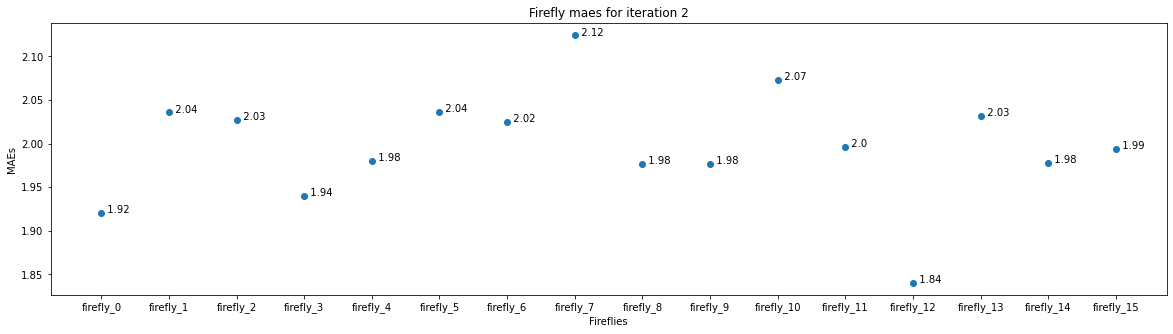


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.2712, 0.2413, 0.2434, 0.2656, 0.2551, 0.2412, 0.244, 0.2216, 0.256, 0.2559, 0.2328, 0.251, 0.2951, 0.2422, 0.2557, 0.2515]

firefly_ranked_indexes
[12, 0, 3, 8, 9, 14, 4, 15, 11, 6, 2, 13, 1, 5, 10, 7]

firefly ranked intensities
[0.295, 0.271, 0.266, 0.256, 0.256, 0.256, 0.255, 0.252, 0.251, 0.244, 0.243, 0.242, 0.241, 0.241, 0.233, 0.222]

Moving the fireflies
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 0 MAE = 1.920220992589999 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 3 MAE = 1.940441813668915 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 8 MAE = 1.9762344147758886 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 9 MAE = 1.9766840155348464 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 14 MAE = 1.9775521470026765 | B is better than A? False
Firefly_

max_depth has changed from 9 to 8.974576290042869 taking a step of size 1
bagging_fraction has changed from 0.8517029587741473 to 0.8526982594074611 taking a step of size 1
bagging_freq has changed from 13 to 12.974576290042867 taking a step of size 1
feature_fraction has changed from 0.6000338774317634 to 0.5995249725876212 taking a step of size 1
lambda_l1 has changed from 11 to 10.936440725107172 taking a step of size 1
lambda_l2 has changed from 14 to 13.93644072510717 taking a step of size 1
Decided to start using meter_id_ord as firefly 12 uses it
Decided to stop using meter_id_binary as firefly 12 doesn't use it
Decided to stop using day_of_year_cyclic as firefly 12 doesn't use it
Decided to start using day_of_week as firefly 12 uses it
Decided to stop using day_of_month as firefly 12 doesn't use it
Decided to start using month_ord as firefly 12 uses it
Decided to stop using month_cyclic as firefly 12 doesn't use it
Decided to start using is_weekend as firefly 12 uses it
Decided

lambda_l2 has changed from 16 to 15.998284612802651 taking a step of size 0.125
Decided to keep using meter_id_ord as firefly 13 already uses it
Decided to stop using meter_id_binary as firefly 13 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 13 doesn't already use it
Decided to stop using day_of_week as firefly 13 doesn't already use it
Decided to stop using day_of_month as firefly 8 doesn't use it
Decided to keep using month_ord as firefly 13 already uses it
Decided to stop using month_cyclic as firefly 13 doesn't already use it
Decided to keep using is_weekend as firefly 13 already uses it
Decided to keep using energy_cluster as firefly 13 already uses it
Decided to keep using num_bedrooms as firefly 13 already uses it
Decided to keep using dwelling_type_ord as firefly 13 already uses it
Decided to stop using dwelling_type_onehot as firefly 8 doesn't use it
Firefly_A = 13 MAE = 2.0317645015288543 | Firefly_B = 9 MAE = 1.9766840155348464 | B is better tha

Decided to keep using is_weekend as firefly 5 already uses it
Decided to start using energy_cluster as firefly 3 uses it
Decided to keep using num_bedrooms as firefly 5 already uses it
Decided to start using dwelling_type_ord as firefly 3 uses it
Decided to stop using dwelling_type_onehot as firefly 5 doesn't already use it
Firefly_A = 5 MAE = 2.0362789003540196 | Firefly_B = 8 MAE = 1.9762344147758886 | B is better than A? True
Intensity difference between 5 and 8 is 0.003697413662620455
learning_rate has changed from 0.017775159869756058 to 0.017786175842464065 taking a step of size 0.125
num_leaves has changed from 403 to 402.9542445059251 taking a step of size 0.125
max_depth has changed from 9 to 9.0 taking a step of size 0.125
bagging_fraction has changed from 0.9680829011398353 to 0.9680030182210828 taking a step of size 0.125
bagging_freq has changed from 9 to 8.99815129316869 taking a step of size 0.125
feature_fraction has changed from 0.5319287209843584 to 0.5320087625836792

Decided to stop using meter_id_binary as firefly 7 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 7 doesn't already use it
Decided to keep using day_of_week as firefly 7 already uses it
Decided to stop using day_of_month as firefly 7 doesn't already use it
Decided to keep using month_ord as firefly 7 already uses it
Decided to stop using month_cyclic as firefly 7 doesn't already use it
Decided to keep using is_weekend as firefly 7 already uses it
Decided to keep using energy_cluster as firefly 7 already uses it
Decided to keep using num_bedrooms as firefly 7 already uses it
Decided to keep using dwelling_type_ord as firefly 7 already uses it
Decided to stop using dwelling_type_onehot as firefly 7 doesn't already use it
Firefly_A = 7 MAE = 2.124064333759938 | Firefly_B = 5 MAE = 2.0362789003540196 | B is better than A? True
Intensity difference between 7 and 5 is 0.00485178591271701
learning_rate has changed from 0.02266177768951443 to 0.022661774028840054 ta

  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3, Firefly 0
Feature groups
['meter_id_ord', 'day_of_week', 'month_ord', 'is_weekend', 'num_bedrooms', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.06054100282751203, 'num_leaves': 1421, 'max_depth': 11, 'bagging_fraction': 0.9791047006277013, 'bagging_freq': 16, 'feature_fraction': 0.5602129527292206, 'lambda_l1': 17, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5602129527292206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5602129527292206
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9791047006277013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9791047006277013
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] 

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.00334
[6666]	valid_0's l1: 1.98005
[9999]	valid_0's l1: 1.96775
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.96775
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.615481976146353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.615481976146353
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.9010504077037207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9010504077037207
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don'

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99275
[6666]	valid_0's l1: 1.98217
Early stopping, best iteration is:
[6630]	valid_0's l1: 1.98144
MAE = 1.9758195936232348, TOE = 0:24:24, Intensity = 0.25615652571669134

Iteration 3, Firefly 5
Feature groups
['meter_id_ord', 'day_of_week', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.01781140244319578, 'num_leaves': 403, 'max_depth': 9, 'bagging_fraction': 0.9678615370320577, 'bagging_freq': 9, 'feature_fraction': 0.532160702744445, 'lambda_l1': 18, 'lambda_l2': 15}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.532160702744445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.532160702744445
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: la

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.07008
[6666]	valid_0's l1: 2.04394
[9999]	valid_0's l1: 2.03222
Did not meet early stopping. Best iteration is:
[9996]	valid_0's l1: 2.03222
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6791546531702505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6791546531702505
[LightGBM] [Warning] lambda_l1 is set=14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14
[LightGBM] [Warning] bagging_fraction is set=0.9103172042200264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9103172042200264
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Training until validation scores d

Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.9165467859324261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9165467859324261
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5676237303567854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5676237303567854
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99341
Early stopping, best iteration is:
[6369]	valid_0's l1: 1.97422
MAE = 1.9722281833006414, TOE = 0:17:21, Intensity = 0.2570902927330325

Iteration 3, Firefly 10
Feature 

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.93685
[6666]	valid_0's l1: 1.87481
[9999]	valid_0's l1: 1.84136
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.84135
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99778
[6666]	valid_0's l1: 1.98122
[9999]	valid_0's l1: 1.97181
Did not meet early stopping. Best iteration is:
[9986]	valid_0's l1: 1.97174
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.8004220745691396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8004220745691396
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.766976500621992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.766976500621992
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
Training until validation scores don't

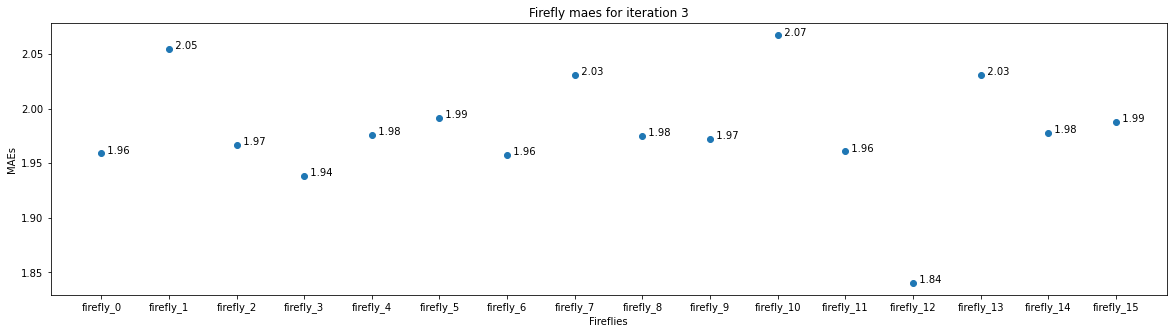


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.2606, 0.2369, 0.2586, 0.2662, 0.2562, 0.252, 0.261, 0.2424, 0.2564, 0.2571, 0.234, 0.2601, 0.2951, 0.2425, 0.2557, 0.253]

firefly_ranked_indexes
[12, 3, 6, 0, 11, 2, 9, 8, 4, 14, 15, 5, 13, 7, 1, 10]

firefly ranked intensities
[0.295, 0.266, 0.261, 0.261, 0.26, 0.259, 0.257, 0.256, 0.256, 0.256, 0.253, 0.252, 0.242, 0.242, 0.237, 0.234]

Moving the fireflies
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 3 MAE = 1.938307473134732 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 6 MAE = 1.9575344868061624 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 0 MAE = 1.959005628178885 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 11 MAE = 1.9608802552159832 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 2 MAE = 1.9664528770320586 | B is better than A? False
Firefly_A 

lambda_l2 has changed from 5 to 5.001625757870139 taking a step of size 0.125
Decided to keep using meter_id_ord as firefly 14 already uses it
Decided to stop using meter_id_binary as firefly 14 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 14 doesn't already use it
Decided to stop using day_of_week as firefly 14 doesn't already use it
Decided to stop using day_of_month as firefly 14 doesn't already use it
Decided to keep using month_ord as firefly 14 already uses it
Decided to stop using month_cyclic as firefly 14 doesn't already use it
Decided to keep using is_weekend as firefly 14 already uses it
Decided to stop using energy_cluster as firefly 14 doesn't already use it
Decided to keep using num_bedrooms as firefly 14 already uses it
Decided to keep using dwelling_type_ord as firefly 14 already uses it
Decided to stop using dwelling_type_onehot as firefly 14 doesn't already use it
Firefly_A = 14 MAE = 1.9774299426518769 | Firefly_B = 11 MAE = 1.9608802552

feature_fraction has changed from 0.9054989289213472 to 0.9054186718967816 taking a step of size 0.125
lambda_l1 has changed from 9 to 9.001859491090851 taking a step of size 0.125
lambda_l2 has changed from 10 to 10.001394618318137 taking a step of size 0.125
Decided to keep using meter_id_ord as firefly 15 already uses it
Decided to stop using meter_id_binary as firefly 15 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 0 doesn't use it
Decided to keep using day_of_week as firefly 15 already uses it
Decided to stop using day_of_month as firefly 15 doesn't already use it
Decided to keep using month_ord as firefly 15 already uses it
Decided to stop using month_cyclic as firefly 15 doesn't already use it
Decided to keep using is_weekend as firefly 15 already uses it
Decided to keep using energy_cluster as firefly 15 already uses it
Decided to keep using num_bedrooms as firefly 15 already uses it
Decided to keep using dwelling_type_ord as firefly 15 already use

Decided to keep using day_of_week as firefly 13 already uses it
Decided to stop using day_of_month as firefly 13 doesn't already use it
Decided to keep using month_ord as firefly 13 already uses it
Decided to stop using month_cyclic as firefly 13 doesn't already use it
Decided to keep using is_weekend as firefly 13 already uses it
Decided to keep using energy_cluster as firefly 13 already uses it
Decided to keep using num_bedrooms as firefly 13 already uses it
Decided to keep using dwelling_type_ord as firefly 13 already uses it
Decided to stop using dwelling_type_onehot as firefly 13 doesn't already use it
Firefly_A = 13 MAE = 2.03087961986666 | Firefly_B = 8 MAE = 1.975019203033097 | B is better than A? True
Intensity difference between 13 and 8 is 0.0034027136345188558
learning_rate has changed from 0.03956054647163897 to 0.03956061599474354 taking a step of size 0.0078125
num_leaves has changed from 96 to 96.00555599335637 taking a step of size 0.0078125
max_depth has changed from 

feature_fraction has changed from 0.8528216846637268 to 0.8528219038815145 taking a step of size 0.0009765625
lambda_l1 has changed from 17 to 16.999969188290443 taking a step of size 0.0009765625
lambda_l2 has changed from 12 to 11.99999229707261 taking a step of size 0.0009765625
Decided to keep using meter_id_ord as firefly 1 already uses it
Decided to stop using meter_id_binary as firefly 1 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 1 doesn't already use it
Decided to stop using day_of_week as firefly 1 doesn't already use it
Decided to stop using day_of_month as firefly 1 doesn't already use it
Decided to keep using month_ord as firefly 1 already uses it
Decided to stop using month_cyclic as firefly 1 doesn't already use it
Decided to keep using is_weekend as firefly 1 already uses it
Decided to keep using energy_cluster as firefly 1 already uses it
Decided to keep using num_bedrooms as firefly 1 already uses it
Decided to keep using dwelling_type_o

  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4, Firefly 0
Feature groups
['meter_id_ord', 'month_ord', 'is_weekend', 'num_bedrooms', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.06083750143455796, 'num_leaves': 1410, 'max_depth': 11, 'bagging_fraction': 0.9784761161621909, 'bagging_freq': 16, 'feature_fraction': 0.5602431729253072, 'lambda_l1': 17, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5602431729253072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5602431729253072
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9784761161621909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9784761161621909
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambd

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.00282
[6666]	valid_0's l1: 1.9793
[9999]	valid_0's l1: 1.96728
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.96728
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6149754764489641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6149754764489641
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.9010946108947122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9010946108947122
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99102
[6666]	valid_0's l1: 1.98043
Early stopping, best iteration is:
[7070]	valid_0's l1: 1.97869
MAE = 1.977793974192664, TOE = 0:22:42, Intensity = 0.255645352121364

Iteration 4, Firefly 5
Feature groups
['meter_id_ord', 'day_of_week', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.018766004798725814, 'num_leaves': 402, 'max_depth': 9, 'bagging_fraction': 0.9668745573005862, 'bagging_freq': 9, 'feature_fraction': 0.5326675644351933, 'lambda_l1': 18, 'lambda_l2': 15}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5326675644351933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5326675644351933
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: l

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.19711
[6666]	valid_0's l1: 2.14006
[9999]	valid_0's l1: 2.11582
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 2.11582
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.677289221310699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.677289221310699
[LightGBM] [Warning] lambda_l1 is set=14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14
[LightGBM] [Warning] bagging_fraction is set=0.9098293057936585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9098293057936585
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Training until validation scores do

Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.9127661329791423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9127661329791423
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5712370732791234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5712370732791234
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.98128
Early stopping, best iteration is:
[4102]	valid_0's l1: 1.97287
MAE = 1.9656504432282524, TOE = 0:10:08, Intensity = 0.25881379609721455

Iteration 4, Firefly 10
Feature groups

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.93685
[6666]	valid_0's l1: 1.87481
[9999]	valid_0's l1: 1.84136
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.84135
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.08515
[6666]	valid_0's l1: 2.05394
[9999]	valid_0's l1: 2.03725
Did not meet early stopping. Best iteration is:
[9991]	valid_0's l1: 2.03721
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7977561604353995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7977561604353995
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7684942199169242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7684942199169242
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
Training until validation scores don

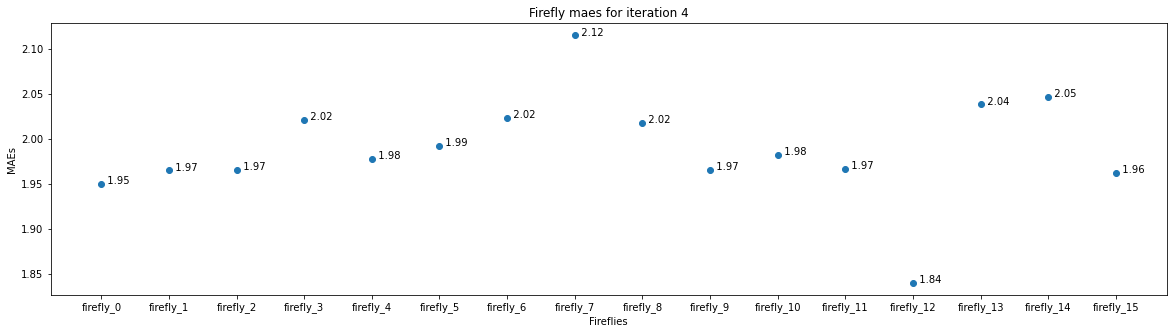


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.2629, 0.2589, 0.2586, 0.2447, 0.2556, 0.252, 0.2441, 0.2235, 0.2455, 0.2588, 0.2545, 0.2583, 0.2951, 0.2406, 0.2388, 0.2597]

firefly_ranked_indexes
[12, 0, 15, 1, 9, 2, 11, 4, 10, 5, 8, 3, 6, 13, 14, 7]

firefly ranked intensities
[0.295, 0.263, 0.26, 0.259, 0.259, 0.259, 0.258, 0.256, 0.254, 0.252, 0.245, 0.245, 0.244, 0.241, 0.239, 0.223]

Moving the fireflies
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 0 MAE = 1.9504711295218777 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 15 MAE = 1.9624559119220182 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 1 MAE = 1.9653149000076209 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 9 MAE = 1.9656504432282524 | B is better than A? False
Firefly_A = 12 MAE = 1.840780442659743 | Firefly_B = 2 MAE = 1.966345581648066 | B is better than A? False
Firefl

Decided to stop using dwelling_type_onehot as firefly 0 doesn't use it
Firefly_A = 5 MAE = 1.9920435960293374 | Firefly_B = 15 MAE = 1.9624559119220182 | B is better than A? True
Intensity difference between 5 and 15 is 0.0018896470517742042
learning_rate has changed from 0.01962194586830511 to 0.019641779262031596 taking a step of size 0.25
num_leaves has changed from 400 to 399.97496217656396 taking a step of size 0.25
max_depth has changed from 9 to 9.0 taking a step of size 0.25
bagging_fraction has changed from 0.9664982055608663 to 0.9662916074544536 taking a step of size 0.25
bagging_freq has changed from 9 to 9.005196529392379 taking a step of size 0.25
feature_fraction has changed from 0.5329949948642738 to 0.5331709184203485 taking a step of size 0.25
lambda_l1 has changed from 18 to 17.99574829413351 taking a step of size 0.25
lambda_l2 has changed from 15 to 14.997637941185282 taking a step of size 0.25
Decided to keep using meter_id_ord as firefly 5 already uses it
Decided

bagging_fraction has changed from 0.8541099779125043 to 0.8541104069985777 taking a step of size 0.001953125
bagging_freq has changed from 13 to 12.99998477940234 taking a step of size 0.001953125
feature_fraction has changed from 0.5991295665277283 to 0.59912931362988 taking a step of size 0.001953125
lambda_l1 has changed from 11 to 11.000026636045906 taking a step of size 0.001953125
lambda_l2 has changed from 14 to 14.000003805149415 taking a step of size 0.001953125
Decided to keep using meter_id_ord as firefly 6 already uses it
Decided to stop using meter_id_binary as firefly 6 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 6 doesn't already use it
Decided to stop using day_of_week as firefly 6 doesn't already use it
Decided to stop using day_of_month as firefly 6 doesn't already use it
Decided to keep using month_ord as firefly 6 already uses it
Decided to stop using month_cyclic as firefly 6 doesn't already use it
Decided to keep using is_weekend as 

num_leaves has changed from 108 to 107.5757393321327 taking a step of size 1
max_depth has changed from 6 to 6.0176775278278045 taking a step of size 1
bagging_fraction has changed from 0.9098293057936585 to 0.9101858738017973 taking a step of size 1
bagging_freq has changed from 18 to 17.87625730520537 taking a step of size 1
feature_fraction has changed from 0.677289221310699 to 0.6752158378370777 taking a step of size 1
lambda_l1 has changed from 14 to 13.858579777377567 taking a step of size 1
lambda_l2 has changed from 16 to 15.876257305205373 taking a step of size 1
Decided to start using meter_id_ord as firefly 12 uses it
Decided to stop using meter_id_binary as firefly 12 doesn't use it
Decided to stop using day_of_year_cyclic as firefly 12 doesn't use it
Decided to start using day_of_week as firefly 12 uses it
Decided to stop using day_of_month as firefly 12 doesn't use it
Decided to start using month_ord as firefly 12 uses it
Decided to stop using month_cyclic as firefly 12 d

  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5, Firefly 0
Feature groups
['meter_id_ord', 'day_of_week', 'month_ord', 'is_weekend', 'num_bedrooms', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.061101555134930575, 'num_leaves': 1399, 'max_depth': 11, 'bagging_fraction': 0.9780901290259364, 'bagging_freq': 16, 'feature_fraction': 0.5602412366806474, 'lambda_l1': 17, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5602412366806474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5602412366806474
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9780901290259364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9780901290259364
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM]

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.07317
[6666]	valid_0's l1: 2.04177
[9999]	valid_0's l1: 2.02589
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 2.02589
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6144733505640503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6144733505640503
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.9013687157322633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9013687157322633
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores do

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99428
Early stopping, best iteration is:
[4010]	valid_0's l1: 1.99096
MAE = 1.978758023390588, TOE = 0:20:21, Intensity = 0.2553963124131274

Iteration 5, Firefly 5
Feature groups
['meter_id_ord', 'month_ord', 'is_weekend', 'num_bedrooms', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.019654425423479224, 'num_leaves': 400, 'max_depth': 9, 'bagging_fraction': 0.9661804529029092, 'bagging_freq': 9, 'feature_fraction': 0.5332915270249752, 'lambda_l1': 18, 'lambda_l2': 15}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5332915270249752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5332915270249752
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_fraction is set=0.96

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.18573
[6666]	valid_0's l1: 2.13035
[9999]	valid_0's l1: 2.10905
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 2.10903
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6755018193358303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6755018193358303
[LightGBM] [Warning] lambda_l1 is set=14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14
[LightGBM] [Warning] bagging_fraction is set=0.909201558412274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.909201558412274
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Training until validation scores do

In [ ]:
num_folds = 3

number_of_iterations = 8
source_intensity = 1

fireflies = population

all_results = [] # will hold array of all the tuples of results + hyper params

#for the number of iterations
print(f"{color.BOLD}Firefly Algorithm hyper parameter optimization{color.END}\n")
start_time = time.time()
for i in tqdm(range(number_of_iterations)):
    
    iteration_results = [] #results of this iteration
    firefly_intensities = [] #corresponding intensities of the fireflies light
    
    #evaluate each firefly
    best_mae = 9999
    best_index = 0
    
    print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}Training the fireflies{color.END}")
    for f in tqdm(range(len(fireflies))):
        
        print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Iteration {i}, Firefly {f}{color.END}")
            
        #getting this models columns
        X_col_groups = fireflies[f][2]
        X_cols = fireflies[f][0]
        this_X_cats = list(set(X_cols).intersection(all_cat)) #getting the categorical values for this X
        #getting this models hyper parameters
        this_params = fireflies[f][1]
        
        #inspecting
        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Feature groups{color.END}")
        print(X_col_groups)
        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper parameters{color.END}")
        print(this_params)
        
        #bug in lgbm which occassionally refuses models based on the hypers and the feature fraction value; fixing this by randomising feature fraction if it fails
        fail_counter=1
        while True:
            #try to run this model
            try:
                #training this model and storing its results (excluding the lgbm model itself as was running out of memory)
                this_run = run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, X_cols, this_X_cats, this_params)
                iteration_results.append(((this_run[0],this_run[1]), # MAE and TOE (not this_run[2] (lgbm_models) to stop running out of memory)
                                          (X_cols,this_params,X_col_groups))) # models description so we can train and use the best lgbm models without having to store all in memory
                firefly_intensities.append(1/this_run[1]**2) #calculating the intensity of this firefly via inverse square law and storing it 
                print(f"MAE = {this_run[1]}, TOE = {str(datetime.timedelta(seconds=round(this_run[0])))}, Intensity = {str(1/this_run[1]**2)}\n")
                
                if this_run[1]<best_mae:
                    best_mae = this_run[1]
                    best_index = f
                break
            #if it fails randomise value of feature fraction as it seems the bug that exists in lgbm library that is unpatched is depending on the feature fraction value https://github.com/microsoft/LightGBM/issues/3679
            except:
                print(f"Firefly {f} failed {fail_counter} times")
                random_new_frac=random.randrange(0,100)/100
                print(f"Changing feature fraction from {this_params['feature_fraction']} to {random_new_frac}")
                this_params["feature_fraction"]=random_new_frac
                fail_counter+=1 
        
    #adding this populations results to all_results
    all_results = all_results + iteration_results
    print(f"{color.BOLD}Best results for iteration {i} is {best_mae} from firefly {best_index}{color.END}")

    #visualizing the maes so we can see how they change for each firefly
    plot_firefly_maes = []
    plot_firefly_names = []
    for result_i in range(len(iteration_results)):
        plot_firefly_maes.append(iteration_results[result_i][0][1])
        plot_firefly_names.append("firefly_"+str(result_i))
        
    fig, ax = plt.subplots(figsize=(20,5))
    ax.scatter(plot_firefly_names, plot_firefly_maes)

    for point_index, txt in enumerate(plot_firefly_maes):
        ax.annotate(str("  ")+str(round(txt,2)), (plot_firefly_names[point_index], plot_firefly_maes[point_index]))

    plt.title(f"Firefly maes for iteration {i}")
    plt.xlabel("Fireflies")
    plt.ylabel("MAEs")
    ax.set_xticks(np.arange(len(fireflies)))
    plt.show()
    fig.savefig(f"..\\Results\\Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}__iter{i}_firefly_MAEs.png")
    plt.close()
    plt.close(fig)
    del fig, ax
    gc.collect()

    
    #if this isn't the last iteration...
    if i<number_of_iterations-1:

        #sorting the fireflies in descending order by their intensities (so best firefly at the start)
        print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}\nSorting the fireflies in order of best intensity{color.END}")
        print("firefly_intensities original order")
        rounded_firefly_intensities = []
        for intensity in firefly_intensities:
            rounded_firefly_intensities.append(round(intensity,4))
        print(rounded_firefly_intensities)
        firefly_ranked_indexes = sorted(range(len(firefly_intensities)), key=lambda k: firefly_intensities[k], reverse=True)
        print("\nfirefly_ranked_indexes")
        print(firefly_ranked_indexes)
        print("\nfirefly ranked intensities")
        rounded_firefly_intensities = []
        for n in firefly_ranked_indexes:
            rounded_firefly_intensities.append(round(firefly_intensities[n],3))
        print(rounded_firefly_intensities)

        #normalizing the intensities
        sum_of_intensities = sum(firefly_intensities)
        firefly_intensities = [float(i)/sum_of_intensities for i in firefly_intensities]

        print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}\nMoving the fireflies{color.END}")

        #move the fireflies
        new_fireflies = fireflies.copy()
        for a in firefly_ranked_indexes:
            firefly_A = fireflies[a]
            step_size_coef = 1 # decrease this every time we find a better firefly
            for b in firefly_ranked_indexes:
                #if this is the same firefly then skip this iteration
                if a==b:
                    continue
                firefly_B = fireflies[b]
                print(f"{color.BOLD}{color.PURPLE}Firefly_A = {a} MAE = {iteration_results[a][0][1]} | Firefly_B = {b} MAE = {iteration_results[b][0][1]} | B is better than A? {iteration_results[a][0][1] > iteration_results[b][0][1]}{color.END}")


                #move firefly A towards firefly B if it's error is better (smaller)
                if(iteration_results[a][0][1] > iteration_results[b][0][1]):
                    intensity_difference = abs(firefly_intensities[b]-firefly_intensities[a])
                    print(f"{color.YELLOW}Intensity difference between {a} and {b} is {intensity_difference}{color.END}")

                    #iteratively moving the hyper parameters
                    new_a_params = params.copy()
                    for key in tuned_hyper_names:
                        #getting the current param value
                        a_param = new_fireflies[a][1][key] # considering changes 
                        b_param = fireflies[b][1][key] # only original value
                        #updating the value based on the intensity
                        temp_new_param = (1-intensity_difference)*a_param + intensity_difference*b_param
                        new_a_params[key] = (1-step_size_coef)*a_param+step_size_coef*temp_new_param
                        
                        print(f"{key} has changed from {a_param} to {new_a_params[key]} taking a step of size {step_size_coef}")

                        #if this key needs to be a whole number, round it
                        if(key in whole_number_hyper_names):
                            new_a_params[key] = int(max(1,round(new_a_params[key])))
                        #clipping fractional keys between 0 and 1
                        if(key in fractional_hyper_names):
                            new_a_params[key] = float(max(0, min(new_a_params[key],1)))

                    
                    
                    #iteratively moving the columns
                    new_a_cols = []
                    new_a_col_groups = []
                    for key in possible_columns.keys():

                        #generate a random number and accept it if it it is within the difference then take the column from firefly b
                        if(random.random()<step_size_coef):
                            if key in fireflies[b][0]:
                                new_a_col_groups+=[key]
                                new_a_cols+=possible_columns[key]
                                print(f"Decided to start using {key} as firefly {b} uses it")
                            else:
                                print(f"Decided to stop using {key} as firefly {b} doesn't use it")

                        #else keep this column as it is currently in firefly a (inc. if it has been added by a prior firefly)
                        else:
                            if key in new_fireflies[a][0]:
                                new_a_col_groups+=[key]
                                new_a_cols+=possible_columns[key]
                                print(f"Decided to keep using {key} as firefly {a} already uses it")
                            else:
                                print(f"Decided to stop using {key} as firefly {a} doesn't already use it")

                    if(len(new_a_col_groups)<=0):
                        new_key=random.choice(list(possible_columns.keys()))
                        new_a_col_groups=[new_key]
                        new_a_cols+=possible_columns[new_key]
                        print(f"No columns clipping length to 1 so randomly choosing to use {new_key}")
                                
                    step_size_coef/=2# decreasing the step size for the next firefly we find
                    #updating this firefly
                    new_fireflies[a] = (new_a_cols, new_a_params, new_a_col_groups)

#                     break #as we only want to move towards the firefly that is better than us

#         #adding some randomness to this firefly
#         print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}\nAdding Noise to the fireflies{color.END}")
#         for a in range(len(fireflies)):
#             #random noise to hyper parameter with a 1/n chance mutating them by +/- up to 10%
#             print(f"{color.BOLD}{color.PURPLE}Mutating Firefly_A = {a}{color.END}")
#             noisy_a_params = new_fireflies[a][1].copy()
#             for key in tuned_hyper_names:
#                 random_chance = random.randrange(len(tuned_hyper_names))==1
#                 if random_chance:
#                     noisy_a_params[key]*=(random.randrange(90,110)/100)
#                     print(f"randomly added noise to {key} changing it from {new_fireflies[a][1][key]} to {noisy_a_params[key]}")
#                    #if this key needs to be a whole number, round it
#                     if(key in whole_number_hyper_names):
#                         noisy_a_params[key] = int(max(1,round(noisy_a_params[key])))
#                     #clipping fractional keys between 0 and 1
#                     if(key in fractional_hyper_names):
#                         noisy_a_params[key] = float(max(0, min(noisy_a_params[key],1)))
                
#             #random bitflipping of columns (1/n chance)
#             noisy_cols = []
#             noisy_cols_groups = []
#             for key in possible_columns.keys():
#                 random_chance = random.randrange(len(possible_columns.keys()))==1
#                 if random_chance:
#                     if key not in new_fireflies[a][0]:
#                         noisy_cols_groups+=[key]
#                         noisy_cols+=possible_columns[key]
#                         print(f"Decided to start using {key} as firefly {a} doesn't already use it and we are randomly walking")
#                     else:
#                         print(f"Decided to stop using {key} as firefly {a} already uses it and we are randomly walking")
#                 else:
#                     if key in new_fireflies[a][0]:
#                         new_a_col_groups+=[key]
#                         new_a_cols+=possible_columns[key]
# #                         print(f"Decided to keep using {key} as firefly {a} already uses it and we are not randomly changing it")
# #                     else:
# #                         print(f"Decided to keep using {key} as firefly {a} doesn't already use it and we are not randomly changing it")
#             if(len(noisy_cols_groups)<=0):
#                     new_key=random.choice(list(possible_columns.keys()))
#                     noisy_cols_groups=[new_key]
#                     noisy_cols+=possible_columns[new_key]
#                     print(f"No columns clipping length to 1 so randomly choosing to use {new_key}")

#             new_fireflies[a] = (noisy_cols, noisy_a_params, noisy_cols_groups)

        #replacing fireflies with the new ones
        fireflies = new_fireflies.copy()
    print("\n\n\n")
    
#visualizing the maes so we can see how they change for each firefly over the iterations
all_firefly_maes = []
plot_firefly_names = []

for all_result_i in range(number_of_iterations):
    iter_firefly_maes = []
    for iter_result_i in range(len(fireflies)):
        iter_firefly_maes.append(all_results[iter_result_i+(all_result_i*len(fireflies))][0][1])
        if all_result_i == 0:
            plot_firefly_names.append("firefly_"+str(iter_result_i))
            
            
    all_firefly_maes.append(iter_firefly_maes)
    

fig, ax = plt.subplots(figsize=(20,15))

plot_iter=0
for this_firefly_maes in all_firefly_maes:
    ax.scatter(plot_firefly_names, this_firefly_maes, label=f"iter_{plot_iter}",marker="x")
    plot_iter+=1
    


plt.legend()
plt.title(f"Firefly maes for iteration {i}")
plt.xlabel("Fireflies")
plt.ylabel("MAEs")
ax.set_xticks(np.arange(len(fireflies)))
plt.show()
fig.savefig(f"..\\Results\\Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}__all_iters_firefly_MAEs.png")
plt.close()
plt.close(fig)
del fig, ax
gc.collect()

            
time_of_execution = time.time()-start_time
print(f"{color.BOLD}Firefly ran {number_of_iterations} iterations with a population of {population_size} in {str(datetime.timedelta(seconds=round(time_of_execution)))}{color.END}\n") 

## Visualising information from the firefly algorithm results
### Box plots of the MAE for the different columns

In [ ]:
columns_maes = {} #dictionary of each columns maes
columnless_mae = {}
#iterating through each column and randomly decide whether or not to pick it
for key in tqdm(possible_columns.keys()):
    column = possible_columns[key][0] # only want to check against one column for the 'in'
    
    # if this column doesn't yet exist in the dict, create it
    if key not in columns_maes:
        columns_maes[key]=[]
    # if this column doesn't yet exist in the dict, create it
    if key not in columnless_mae:
        columnless_mae[key]=[]

    #iterating through every single models results
    for i in range(len(all_results)):
        
        #if this column was used by the model
        if column in all_results[i][1][0]:
            # adding this models mae to the dict entry for this column
            columns_maes[key].append(all_results[i][0][1])
            
        #else this column wasn't used by the model
        else:
            # adding this models mae to the dict entry for this column
            columnless_mae[key].append(all_results[i][0][1])

# print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}MAEs for each model which contains columns of each type{color.END}")
# pprint(columns_maes)

# function for setting the box colour
def set_box_color(bp, color_line, color_fill):
    plt.setp(bp['whiskers'], color=color_line)
    plt.setp(bp['caps'], color=color_line)
    plt.setp(bp['medians'], color=color_line)
    plt.setp(bp['fliers'], color=color_fill)
    plt.setp(bp['boxes'], color=color_fill)
    plt.setp(bp['means'], color=color_line)

    
### plotting a boxplot of these ###
# getting the 2 dicts we will plot
labels, data_columns = columns_maes.keys(), columns_maes.values()
data_columnless = columnless_mae.values()

#plotting these 2 dicts next to each other
fig = plt.figure(figsize=(25,10))
bp_dict_columns = plt.boxplot(data_columns,showmeans=True,positions=np.array(range(len(labels)))*2.0-0.4,patch_artist=True) # getting dictionary returned from boxplot
bp_dict_columnless = plt.boxplot(data_columnless,showmeans=True,positions=np.array(range(len(labels)))*2.0+0.4,patch_artist=True) # getting dictionary returned from boxplot

#colouring them
set_box_color(bp_dict_columns, '#416338','#b0dba4')
set_box_color(bp_dict_columnless, '#783d2b','#dbb1a4')

#annotating the plot
plt.title("Box plot of MAEs for the different columns", fontsize=20)
plt.xlabel("Column groups", fontsize=17)
plt.ylabel("MAE", fontsize=17)

#creating the legend
plt.plot([], c='#b0dba4',label="MAEs of models that used this column")
plt.plot([], c='#dbb1a4',label="MAEs of models that didn't use this column")
plt.legend()


## adding overlayed values to the boxplot

# stats for with columns
column_means = []
column_medians = []
column_std = []
for key in columns_maes.keys():
    column_means.append(np.mean(columns_maes[key]))
    column_medians.append(np.median(columns_maes[key]))
    column_std.append(np.std(columns_maes[key]))
for i, line in enumerate(bp_dict_columns['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n m={:.2f}\n σ={:.2f}'.format(column_means[i], column_medians[i], column_std[i])
    plt.text(x, y, text, horizontalalignment='center')
    
# stats for without columns
columnless_means = []
columnless_medians = []
columnless_std = []
for key in columnless_mae.keys():
    columnless_means.append(np.mean(columnless_mae[key]))
    columnless_medians.append(np.median(columnless_mae[key]))
    columnless_std.append(np.std(columnless_mae[key]))
for i, line in enumerate(bp_dict_columnless['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n m={:.2f}\n σ={:.2f}'.format(columnless_means[i], columnless_medians[i], columnless_std[i])
    plt.text(x, y, text, horizontalalignment='center')


plt.xticks(range(0, len(labels)*2,2), labels)

plt.show()

fig.savefig(f"..\\Results\\Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}_Box_MAEs.png")

plt.close(fig)
del fig
gc.collect()

## Box and swarm plot to better inspect the distribution

In [ ]:
colourBlindFriendly = False # make graph colourBlindFriendly (pink to blue instead of red to green)

#normalizing the std
max_std = max(column_std)
column_std = [float(i)/max_std for i in column_std]

#gradient of green to red based on each columns stats
box_grad_palette = {}
for i in range(len(column_std)):
    box_grad_palette[i] = [column_std[i], 1-column_std[i],1 if colourBlindFriendly else 0] #based on std

fig=plt.figure(figsize=(25,10))
sns.set(context='notebook', style='white')
sns.utils.axlabel(xlabel="Column Groups", ylabel="MAE", fontsize=16)
sns.boxplot(data=list(data_columns), width=.18, palette=box_grad_palette)

#slightly paler gradient to make it stand out from the box
swarm_grad_palette = box_grad_palette.copy()
for i in range(len(swarm_grad_palette)):
    #fading it to white
    #adding to red to make it paler
    swarm_grad_palette[i][0] = swarm_grad_palette[i][0]+0.3 if swarm_grad_palette[i][0]+0.3<1 else 1
    #adding to green to make it paler
    swarm_grad_palette[i][1] = swarm_grad_palette[i][1]+0.3 if swarm_grad_palette[i][1]+0.3<1 else 1
    #adding to blue to make it paler
    if colourBlindFriendly:
        swarm_grad_palette[i][2] = swarm_grad_palette[i][2]+0.3 if swarm_grad_palette[i][2]+0.3<1 else 1


sns.swarmplot(data=list(data_columns), size=7, edgecolor="black", linewidth=.6, palette=swarm_grad_palette)

plt.xticks(plt.xticks()[0], labels)

plt.title("Box and Swarm plots of MAEs for the different columns", fontsize=20)

plt.show()
fig.savefig(f"..\\Results\\Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}_BoxSwarm_MAEs_GRAD_STD.png")
plt.close(fig)
del fig
gc.collect()

### Main Effects Plots

In [ ]:
#array of the hyperparameters we tuned
arr_hypers = ["learning_rate","num_leaves","max_depth","bagging_fraction","bagging_freq","feature_fraction","lambda_l1","lambda_l2"]
arr_best_hypers = []
#iterate through each of these hypers
for hyper in tqdm(arr_hypers):

    df_max_depth = pd.DataFrame(columns = [hyper,"MAE"])

    #iterating through each column and randomly decide whether or not to pick it
    #iterating through every single models results
    for i in range(len(all_results)):
        # adding this models mae to the dict entry for this column
        df_max_depth.loc[i] = [all_results[i][1][1][hyper],all_results[i][0][1]]

    #sort in ascending order by the params values
    df_all = df_max_depth.sort_values(by=[hyper])
    # display(df_all)

    #grouping together by value and calculating mean
    grouped_df = df_all.groupby(hyper)
    mean_df = grouped_df.mean().reset_index()
    #display(mean_df)
    
    # the minimum point
    df_min = mean_df[mean_df['MAE']==mean_df['MAE'].min()]
    arr_best_hypers.append(df_min[hyper].values)
    display(df_min)

    #plotting the stats for this param 
    fig = plt.figure(figsize=(10,5))
    print(arr_best_hypers)
    
    plt.scatter(df_min[hyper], df_min.MAE, label="Minimum Average MAE", color="lime", marker="o",s=200)
    plt.plot(mean_df[hyper], mean_df.MAE, label="Line of mean MAEs", color="black") # line of means
    plt.scatter(df_all[hyper], df_all.MAE, label="Scatter of MAE values", color="darkorange", marker="x") # scatter of values
    plt.plot(np.unique(df_all[hyper]), 
             np.poly1d(np.polyfit(df_all[hyper], df_all.MAE, 3))
             (np.unique(df_all[hyper])), label="3rd Degr Regressor Line", color="mediumorchid") # line of best fit from a simple regressor

    plt.title(f"MAEs for {hyper} values", fontsize=15)
    plt.xlabel(f"{hyper} values", fontsize=13)
    plt.ylabel("MAE", fontsize=13)
    
    plt.legend()

    plt.show()
    fig.savefig(f"..\\Results\\Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}_scatter_{hyper}.png")
    plt.close(fig)
    del fig
    gc.collect()

### inspecting stats on all models TOE and MAE

In [ ]:
#inspecting the min/max/mean of time of execution of the models we tested in firefly algorithm
all_toes = []
all_maes = [] 

for i in range(len(all_results)):
    #getting the results for this model
    all_toes.append(all_results[i][0][0])
    all_maes.append(all_results[i][0][1])
    
print()
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}min time of execution = {color.END}{str(datetime.timedelta(seconds=round(min(all_toes))))}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}max time of execution = {color.END}{str(datetime.timedelta(seconds=round(max(all_toes))))}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}mean time of execution = {color.END}{str(datetime.timedelta(seconds=round(np.mean(all_toes))))}")
print()
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}min MAE = {color.END}{min(all_maes)}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}max MAE= {color.END}{max(all_maes)}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}mean MAE = {color.END}{np.mean(all_maes)}")

## Inspecting the results of the hyper parameter optimization

In [ ]:
best_index = 0
best_mae = 999999

for i in range(len(all_results)):
    #getting the results for this model
    LGBM_TOE = all_results[i][0][0]
    LGBM_MAE = all_results[i][0][1]
    #displaying the results
    print(f"{color.BOLD}{color.RED}{color.UNDERLINE}iteration {int(i/population_size)} individual {i%population_size} {color.END}")
    print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:{color.END} {str(datetime.timedelta(seconds=round(LGBM_TOE)))}")
    print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {LGBM_MAE}")
    print("")
    
    #keeping track of the best performing model
    if(LGBM_MAE<best_mae):
        best_mae=LGBM_MAE
        best_index = i
print("best model is at iteration",int(best_index/population_size),"individual",best_index%population_size,"with a MAE of",best_mae)

## Training a model based on the best models 
* Done this as no longer storing the models in memory as was running out
* So instead just storing the configuration
* Then this is used to retrain a model with that configuration
    * Should fix the problem of running out of memory whilst running the FA

In [ ]:
#no longer need all results only the best one
best_results = all_results[best_index]
del all_results
gc.collect()

In [ ]:
best_X_cols = best_results[1][0]
best_X_cats = list(set(best_X_cols).intersection(all_cat)) #getting the categorical values for this X
best_params = best_results[1][1]
best_run = run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, best_X_cols, best_X_cats, best_params)

## Making predictions on best model

In [ ]:
#making predictions based on the best performing model and displaying it's information
BEST_LGBM_MODELS = best_run[2] #getting the lgbm_models from the best index
BEST_LGBM_FORECASTS = df_preds.copy()
start_time = time.time() 

#calculating the average preds by summing the weighted preds for each folds model
for i in range(len(BEST_LGBM_MODELS)):
    pred_forecasts = BEST_LGBM_MODELS[i].predict(BEST_LGBM_FORECASTS[best_results[1][0]], num_iteration=BEST_LGBM_MODELS[i].best_iteration_) #predicting the unkown df_preds
    BEST_LGBM_FORECASTS[y_col] += pred_forecasts / num_folds #weighting the predictions for BEST_LGBM_FORECASTS for this fold and adding to df_preds y column 
BEST_LGBM_FORECASTS["meter_reading"] = BEST_LGBM_FORECASTS.meter_reading.clip(lower=0) #clip meter_reading so no predictions lower than 0
execution_time = time.time() - start_time

## Inspecting information on best model

In [ ]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}best model came from iteration {int(best_index/population_size)} individual {best_index%population_size}{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:  {color.END}{str(datetime.timedelta(seconds=round(best_results[0][0])))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for predictions: {color.END}{str(datetime.timedelta(seconds=round(execution_time)))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Total time of execution: {color.END}{str(datetime.timedelta(seconds=round(best_results[0][0]+execution_time)))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {best_results[0][1]}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}preds set with the next years forecasts for each meter{color.END}")
display(BEST_LGBM_FORECASTS[["meter_id","date","meter_reading"]])
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(best_results[1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(best_results[1][1])

## Saving the description of the best model

In [ ]:
BEST_LGBM_FORECASTS.to_pickle(f"..\\Results\\Firefly Algorithm\\f{population_size}_i{number_of_iterations}_best_model_daily_forecasts.pkl")

In [ ]:
import pickle

desc_disc = {
    "time_of_execution_skf-cv":str(datetime.timedelta(seconds=round(best_results[0][0]))),
    "time_of_execution_preds":str(datetime.timedelta(seconds=round(execution_time))),
    "time_of_execution_total":str(datetime.timedelta(seconds=round(best_results[0][0]+execution_time))),
    "MAE":best_results[0][1],
    "features":best_results[1][0],
    "params":best_results[1][1]
}

with open(f"..\\Results\\Firefly Algorithm\\f{population_size}_i{number_of_iterations}_best_model_desc.pkl", 'wb') as handle:
    pickle.dump(desc_disc, handle, protocol=pickle.HIGHEST_PROTOCOL)

pprint(desc_disc)
    
# verifying it saved correctly and can be loaded back
with open(f"..\\Results\\Firefly Algorithm\\f{population_size}_i{number_of_iterations}_best_model_desc.pkl", 'rb') as handle:
    desc_disc_loaded = pickle.load(handle)
print(desc_disc == desc_disc_loaded)

# Converting into monthly forecasts

In [ ]:
#restructuring into the original multiple time series format
#aggregating up the total sum of the months predictions
df_monthly_forecasts = BEST_LGBM_FORECASTS.groupby(["meter_id", "month_ord"])["meter_reading"].sum().unstack()

#rename ordinal encoded month with its corresponding name
df_monthly_forecasts.rename(columns={1:"Jan", 2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}, inplace=True)
#resetting the index 
df_monthly_forecasts.reset_index(inplace=True)
df_monthly_forecasts.index.name = None # removing index column
df_monthly_forecasts.columns.name = None # removing columns name

display(df_monthly_forecasts)

## Saving these monthly predictions to be submitted to competition
* Saving predictions ready to be submitted so I can get the MAE on the test set

In [ ]:
df_monthly_forecasts.to_csv(f"..\\Results\\Firefly Algorithm\\f{population_size}_i{number_of_iterations}_best_model_monthly_forecasts.csv", index=False, header=True)

# Plotting these monthly forecasts
## Renaming months to dates for plotting

In [ ]:
df_monthly_forecasts.rename(columns={"Jan":"2018-01", "Feb":"2018-02","Mar":"2018-03","Apr":"2018-04","May":"2018-05","Jun":"2018-06","Jul":"2018-07","Aug":"2018-08","Sep":"2018-09","Oct":"2018-10","Nov":"2018-11","Dec":"2018-12"}, inplace=True)
df_monthly_forecasts

## Restructuring forecasts into daily predictions to plot on top of monthly preds

In [ ]:
#daily forecasts to plot on top of monthly
df_daily_forecasts = BEST_LGBM_FORECASTS.groupby(["meter_id","date"])["meter_reading"].sum().unstack()

#resetting the index 
df_daily_forecasts.reset_index(inplace=True)
df_daily_forecasts.index.name = None # removing index column
df_daily_forecasts.columns.name = None # removing columns name

df_daily_forecasts

## loading training data and aggregating into months

In [ ]:
#loading the training data
print("training data")
df_train_daily = pd.read_pickle("../Data/Preprocessed_Data/consumption_daily_nan_interpolated.pkl").fillna(0)

#aggregating up into months
meter_id=df_monthly_forecasts["meter_id"]
df_train_monthly = pd.DataFrame(columns=["meter_id"])
df_train_monthly["meter_id"] = meter_id


#for each month in the range of dates
resample_size="M"
for new_sample in tqdm(pd.date_range(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31), freq = resample_size),position=0):

    #get this columns name as a string
    columnName = str(new_sample.date())[:7]
    #get all columns that relate to this new sample
    columns = [i for i in df_train_daily.columns.values[1:] if i.startswith(columnName)]

    #sum these up into a value for the new sample size
    df_train_monthly[columnName] = df_train_daily[columns].sum(axis=1)

display(df_train_daily)
display(df_train_monthly)

## Plotting the predictions against the training data

In [ ]:
num_plots = 10
for pid in tqdm(range(0,3248)):
    if pid>num_plots:
        break
        
    #getting the row corresponding to this meter_id
    meter_id = df_daily_forecasts.iloc[pid,0]
    this_train_month = df_train_monthly.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    this_preds_month = df_monthly_forecasts.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    
    #converting index to datetime for ease of plots key
    this_train_month.index=pd.to_datetime(this_train_month.index)
    this_preds_month.index=pd.to_datetime(this_preds_month.index)
    
    #creating figure
    fig = plt.figure(figsize=(20,10))
    
    #plotting the monthly predictions
    plt.title("Meter '"+str(meter_id)+"' monthly forecasts and historical data", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Energy Usage kWh")
    plt.plot(this_train_month, label="training monthly energy", lw=1,color="skyblue", marker="x")
    plt.plot(this_preds_month, label="forecast monthly energy", lw=1,color="mediumorchid", marker="x")
    
    #annotations
    plt.legend(fontsize=20)
    plt.locator_params(nbins=24)
    
    plt.show()
    fig.savefig(f"..\\Results\\Firefly Algorithm\\Plots\\forecasts\\f{population_size}_i{number_of_iterations}_forecasts_{pid}_{meter_id}.png")

    fig.clf()
    fig.clear()
    plt.close()
    del fig, this_train_month, this_preds_month
    gc.collect()

# Training a model based on the main effects
* Running on the hyper params determined by main effects (setting that gave the lowest mean result)

In [ ]:
# treating columns like main effects: accepting those whose mean error with the column is better than that without the column
main_columm_types = []
i=0
for key in possible_columns.keys():
    print(key,column_means[i]<columnless_means[i])
    main_columm_types.append(key)
    i+=1 
print(main_columm_types)

In [ ]:
#inspecting the stored best values for each hyper as determined by the main effects plot
#(value which resulted in the lowest average MAE on the val set)
print(arr_hypers)
print(arr_best_hypers) 

In [ ]:
start_time = time.time()
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Running with main effects determined configuration{color.END}")

print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Using the features{color.END}")
X_cols =[]

for key in main_columm_types:
    X_cols+=(possible_columns[key])
this_X_cats = list(set(X_cols).intersection(all_cat)) #getting the categorical values for this X
print(X_cols)

print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Using the main effects hyper parameters{color.END}")
this_params = params.copy()
this_params["learning_rate"] = arr_best_hypers[0][0]
this_params["max_depth"] = int(arr_best_hypers[2][0])
this_params["num_leaves"] = int(arr_best_hypers[1][0])
this_params["bagging_fraction"] = arr_best_hypers[3][0]
this_params["bagging_freq"] = int(arr_best_hypers[4][0])
this_params["feature_fraction"] = arr_best_hypers[5][0]
this_params["lambda_l1"] = int(arr_best_hypers[6][0])
this_params["lambda_l2"] = int(arr_best_hypers[7][0])
pprint(this_params)

#train the model with this hyper param config and store it's results
results=((run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, X_cols, this_X_cats, this_params),(X_cols,this_params)))
print("\n\n\n")
time_of_execution = time.time()-start_time
print(f"{color.BOLD}Trained the model in {str(datetime.timedelta(seconds=round(time_of_execution)))}{color.END}\n")

# Forecasting from the main effects model

In [ ]:
#making predictions based on the best performing model and displaying it's information
main_effects_models = results[0][2] #getting the lgbm_models from the best index
main_effects_forecasts = df_preds.copy()

#calculating the average preds by summing the weighted preds for each folds model
for i in range(len(main_effects_models)):
    pred_forecasts = main_effects_models[i].predict(main_effects_forecasts[results[1][0]], num_iteration=main_effects_models[i].best_iteration_) #predicting the unkown df_preds
    main_effects_forecasts[y_col] += pred_forecasts / num_folds #weighting the predictions for BEST_LGBM_FORECASTS for this fold and adding to df_preds y column 
main_effects_forecasts["meter_reading"] = main_effects_forecasts.meter_reading.clip(lower=0) #clip meter_reading so no predictions lower than 0

display(main_effects_forecasts)

# Comparing the val error of the main effects vs the best from Firefly algorithm tuning
## Firefly Algorithm summary

In [ ]:
best_index

In [ ]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}FA best model came from iteration {int(best_index/population_size)} individual {best_index%population_size}{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {best_results[0][1]}\n")
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(best_results[1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(best_results[1][1])

## Main effects based model summary

In [ ]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Main effects model based on results of FA{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {results[0][1]}\n")
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(results[1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(results[1][1])

#### Conclusion:
the best model from the FA is way better than the main effects of the FA


# Save the main effects description

In [ ]:
import pickle

a = {'hello': 'world'}
desc_disc = {
    "MAE":results[0][1],
    "features":results[1][0],
    "params":results[1][1]
}

with open(f"..\\Results\\Firefly Algorithm\\f{population_size}_i{number_of_iterations}_main_effects_desc.pkl", 'wb') as handle:
    pickle.dump(desc_disc, handle, protocol=pickle.HIGHEST_PROTOCOL)

pprint(desc_disc)
    
# verifying it saved correctly and can be loaded back
with open(f"..\\Results\\Firefly Algorithm\\f{population_size}_i{number_of_iterations}_main_effects_desc.pkl", 'rb') as handle:
    desc_disc_loaded = pickle.load(handle)
print(desc_disc == desc_disc_loaded)

# Formatting the main effects forecasts and saving them

# Converting into monthly forecasts

In [ ]:
#restructuring into the original multiple time series format
#aggregating up the total sum of the months predictions
df_monthly_forecasts = main_effects_forecasts.groupby(["meter_id", "month_ord"])["meter_reading"].sum().unstack()

#rename ordinal encoded month with its corresponding name
df_monthly_forecasts.rename(columns={1:"Jan", 2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}, inplace=True)
#resetting the index 
df_monthly_forecasts.reset_index(inplace=True)
df_monthly_forecasts.index.name = None # removing index column
df_monthly_forecasts.columns.name = None # removing columns name

display(df_monthly_forecasts)

## Saving these monthly predictions to be submitted to competition
* Saving predictions ready to be submitted so I can get the MAE on the test set

In [ ]:
df_monthly_forecasts.to_csv(f"..\\Results\\Firefly Algorithm\\f{population_size}_i{number_of_iterations}_main_effects_monthly_forecasts.csv", index=False, header=True)

# Plotting these monthly forecasts
## Renaming months to dates for plotting

In [ ]:
df_monthly_forecasts.rename(columns={"Jan":"2018-01", "Feb":"2018-02","Mar":"2018-03","Apr":"2018-04","May":"2018-05","Jun":"2018-06","Jul":"2018-07","Aug":"2018-08","Sep":"2018-09","Oct":"2018-10","Nov":"2018-11","Dec":"2018-12"}, inplace=True)
df_monthly_forecasts

## Restructuring forecasts into daily predictions to plot on top of monthly preds

In [ ]:
#daily forecasts to plot on top of monthly
df_daily_forecasts = main_effects_forecasts.groupby(["meter_id","date"])["meter_reading"].sum().unstack()

#resetting the index 
df_daily_forecasts.reset_index(inplace=True)
df_daily_forecasts.index.name = None # removing index column
df_daily_forecasts.columns.name = None # removing columns name

df_daily_forecasts

## loading training data and aggregating into months

In [ ]:
#loading the training data
print("training data")
df_train_daily = pd.read_pickle("../Data/Preprocessed_Data/consumption_daily_nan_interpolated.pkl").fillna(0)

#aggregating up into months
meter_id=df_monthly_forecasts["meter_id"]
df_train_monthly = pd.DataFrame(columns=["meter_id"])
df_train_monthly["meter_id"] = meter_id


#for each month in the range of dates
resample_size="M"
for new_sample in tqdm(pd.date_range(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31), freq = resample_size),position=0):

    #get this columns name as a string
    columnName = str(new_sample.date())[:7]
    #get all columns that relate to this new sample
    columns = [i for i in df_train_daily.columns.values[1:] if i.startswith(columnName)]

    #sum these up into a value for the new sample size
    df_train_monthly[columnName] = df_train_daily[columns].sum(axis=1)

display(df_train_daily)
display(df_train_monthly)

## Plotting the predictions against the training data

In [ ]:
num_plots = 10
for pid in tqdm(range(0,3248)):
    if pid>num_plots:
        break
        
    #getting the row corresponding to this meter_id
    meter_id = df_daily_forecasts.iloc[pid,0]
    this_train_month = df_train_monthly.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    this_preds_month = df_monthly_forecasts.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    
    #converting index to datetime for ease of plots key
    this_train_month.index=pd.to_datetime(this_train_month.index)
    this_preds_month.index=pd.to_datetime(this_preds_month.index)
    
    #creating figure
    fig = plt.figure(figsize=(20,10))
    
    #plotting the monthly predictions
    plt.title("Meter '"+str(meter_id)+"' monthly forecasts and historical data", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Energy Usage kWh")
    plt.plot(this_train_month, label="training monthly energy", lw=1,color="skyblue", marker="x")
    plt.plot(this_preds_month, label="forecast monthly energy", lw=1,color="mediumorchid", marker="x")
    
    #annotations
    plt.legend(fontsize=20)
    plt.locator_params(nbins=24)
    
    plt.show()
    fig.savefig(f"..\\Results\\Firefly Algorithm\\Plots\\forecasts\\main_effects\\f{population_size}_i{number_of_iterations}_forecasts_{pid}_{meter_id}.png")

    fig.clf()
    fig.clear()
    plt.close()
    del fig, this_train_month, this_preds_month
    gc.collect()